<a href="https://colab.research.google.com/github/NguyenVu06/BigDataSpark/blob/master/Logistic_Regressionof_WIKIArticles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Spark installation on Colab
# !apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz
!tar xf spark-3.0.0-bin-hadoop3.2.tgz
!pip install -q findspark
!rm -rf spark-3.0.0-bin-hadoop3.2.tgz

In [ ]:
# Set JAVA_HOME and SPARK_HOME
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "spark-3.0.0-bin-hadoop3.2"

import findspark
findspark.init("spark-3.0.0-bin-hadoop3.2")# SPARK_HOME



In [ ]:
import sys
import re
import numpy as np
from numpy import dot
from numpy.linalg import norm
from operator import add

from pyspark.sql import SparkSession
from pyspark import SparkContext
import matplotlib.pyplot as plt

regex = re.compile('[^a-zA-Z]')
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = SparkContext.getOrCreate()



In [ ]:
!wget https://s3.amazonaws.com/metcs777/SmallTrainingData.txt

In [ ]:
pages=sc.textFile("SmallTrainingData.txt")

In [ ]:
pages.take(1)

['<doc id="AU35" url="http://www.austlii.edu.au/au/cases/cth/FCA/2006/1069.html" title="fulltext/06_1069.xml">consideration of an application for a stay pending an appeal.native titleI have before me an application by notice of motion filed on 30 June 2006 by which the applicant seeks an order that two orders of his Honour Justice Dowsett made on 6 October 2005 and 19 June 2006 be stayed pending the determination of an appeal to the Full Court of this Court.On 6 October 2005, his Honour made an order that \'the applicant file and serve an amended application on or before 14 October 2005, in default thereof the application stands dismissed\' .His Honour also ordered that the Native Title Registrar contact the applicant to coordinate continued negotiations between the applicant group and other claimant groups in relation to overlapping claims concerning claims made by members of the Wiri People in connection with \'Wiri country\' defined by reference to particular claim boundaries.His Ho

In [ ]:
# Assumption: Each document is stored in one line of the text file
# We need this count later ... 
numberOfDocs = pages.count()

print(numberOfDocs)

# Each entry in validLines will be a line from the text file
validLines = pages.filter(lambda x : 'id' in x and 'url=' in x)

# Now, we transform it into a set of (docID, text) pairs
keyAndText = pages.map(lambda x : (x[x.index('id="') + 4 : x.index('" url=')], x[x.index('">') + 2:][:-6])) 

keyAndText.take(1)

3442


[('AU35',
  "consideration of an application for a stay pending an appeal.native titleI have before me an application by notice of motion filed on 30 June 2006 by which the applicant seeks an order that two orders of his Honour Justice Dowsett made on 6 October 2005 and 19 June 2006 be stayed pending the determination of an appeal to the Full Court of this Court.On 6 October 2005, his Honour made an order that 'the applicant file and serve an amended application on or before 14 October 2005, in default thereof the application stands dismissed' .His Honour also ordered that the Native Title Registrar contact the applicant to coordinate continued negotiations between the applicant group and other claimant groups in relation to overlapping claims concerning claims made by members of the Wiri People in connection with 'Wiri country' defined by reference to particular claim boundaries.His Honour also ordered that the matter otherwise be adjourned to 31 March 2006 at 10.15am.On 19 June 2006,

In [ ]:
# The following function gets a list of dictionaryPos values,
# and then creates a TF vector
# corresponding to those values... for example,
# if we get [3, 4, 1, 1, 2] we would in the
# end have [0, 2/5, 1/5, 1/5, 1/5] because 0 appears zero times,
# 1 appears twice, 2 appears once, etc.

def buildArray(listOfIndices):
    
    returnVal = np.zeros(20000)
    
    for index in listOfIndices:
        returnVal[index] = returnVal[index] + 1
    
    mysum = np.sum(returnVal)
    
    returnVal = np.divide(returnVal, mysum)
    
    return returnVal



# Cosine Similarity of two vectors 
def cousinSim (x, y):
	normA = np.linalg.norm(x)
	normB = np.linalg.norm(y)
	return np.dot(x,y)/(normA*normB)

In [ ]:
# Now, we split the text in each (docID, text) pair into a list of words
# After this step, we have a data set with
# (docID, ["word1", "word2", "word3", ...])
# We use a regular expression here to make
# sure that the program does not break down on some of the documents

# remove all non letter characters

keyAndListOfWords = keyAndText.map(lambda x : (str(x[0]), regex.sub(' ', x[1]).lower().split()))



In [ ]:
# Now get the top 20,000 words... first change (docID, ["word1", "word2", "word3", ...])
# to ("word1", 1) ("word2", 1)...
allWords = keyAndListOfWords.flatMap(lambda x: x[1]).map(lambda x: (x, 1))

# Now, count all of the words, giving us ("word1", 1433), ("word2", 3423423), etc.
allCounts = allWords.reduceByKey(add)

# Get the top 20,000 words in a local array in a sorted format based on frequency
topWords = allCounts.top(20000, lambda x: x[1])

# 
print("Top Words in Corpus:", allCounts.top(10, key=lambda x: x[1]))

# We'll create a RDD that has a set of (word, dictNum) pairs
# start by creating an RDD that has the number 0 through 20000
# 20000 is the number of words that will be in our dictionary
topWordsK = sc.parallelize(range(20000))
# another option: 

# Now, we transform (0), (1), (2), ... to ("MostCommonWord", 1)
# ("NextMostCommon", 2), ...
# the number will be the spot in the dictionary used to tell us
# where the word is located
dictionary = topWordsK.map (lambda x : (topWords[x][0], x))

dictionary.cache()
print("Word Postions in our Feature Matrix. Last 20 words in 20k positions: ", dictionary.top(20, lambda x : x[1]))



Top Words in Corpus: [('the', 447995), ('of', 205873), ('and', 177099), ('in', 158991), ('to', 144197), ('a', 125478), ('was', 66687), ('for', 52673), ('on', 50806), ('s', 50308)]
Word Postions in our Feature Matrix. Last 20 words in 20k positions:  [('morelos', 19999), ('odisha', 19998), ('chittagong', 19997), ('sirte', 19996), ('fiqh', 19995), ('sajjada', 19994), ('cra', 19993), ('restarted', 19992), ('severus', 19991), ('ngan', 19990), ('magnolia', 19989), ('hornets', 19988), ('symmetric', 19987), ('abolitionist', 19986), ('payoff', 19985), ('lehmann', 19984), ('qasim', 19983), ('dreyer', 19982), ('harkleroad', 19981), ('cain', 19980)]


In [ ]:
#function to look up frequency position. words in an array form
def getfp(inRdd, words):
    result = []
    for w in words:
        fp = inRdd.lookup(w)
        if not fp:
            result.append([-1])
        else:
            result.append(fp)
    return result
        

In [ ]:
################### TASK 1 Output  ##################

# get the frequency position for the following words
getfp(dictionary, ['applicant', 'and', 'attack', 'protein', 'aefwe', 'car', 'for'])

[[346], [2], [502], [3014], [-1], [608], [7]]

In [ ]:
################### TASK 2  ##################

# Next, we get a RDD that has, for each (docID, ["word1", "word2", "word3", ...]),
# ("word1", docID), ("word2", docId), ...

allWordsWithDocID = keyAndListOfWords.flatMap(lambda x: ((j, x[0]) for j in x[1]))


# Now join and link them, to get a set of ("word1", (dictionaryPos, docID)) pairs
allDictionaryWords = dictionary.join(allWordsWithDocID) #Correct

# Now, we drop the actual word itself to get a set of (docID, dictionaryPos) pairs
justDocAndPos = allDictionaryWords.map(lambda x: (x[1][1], x[1][0])) #Correct


# Now get a set of (docID, [dictionaryPos1, dictionaryPos2, dictionaryPos3...]) pairs
allDictionaryWordsInEachDoc = justDocAndPos.groupByKey().map(lambda x: (x[0], list(x[1])))


# The following line this gets us a set of
# (docID,  [dictionaryPos1, dictionaryPos2, dictionaryPos3...]) pairs
# and converts the dictionary positions to a bag-of-words numpy array...
allDocsAsNumpyArrays = allDictionaryWordsInEachDoc.map(lambda x: (x[0], buildArray(x[1])))

# allDocsAsNumpyArrays contains the 20000 variables of dictionary words by frequency position
# and each has a respective TF and this will be used in learning the logistic regression model

# convert docID to the Y response variables of 0 and 1. 1 for Id containing AU
# create method to quickly conver AU to 1 and everything else to 0
def isAU(stringIn):
    return int(stringIn[:2]=="AU")

# map DocID to int 1 or 0 and cache model to be used in logistic regression
# cache this RDD to be used
textModelRDD = allDocsAsNumpyArrays.map(lambda x: (isAU(x[0]), x[1])).cache()



In [ ]:
allDocsAsNumpyArrays.first()

('AU35',
 array([0.11425061, 0.06511057, 0.02272727, ..., 0.        , 0.        ,
        0.        ]))

In [ ]:
#Define some functions to calculate LLH and perform Gradient descent

# calculate the dot product of x an r:
def calcTheta(x_np, r_np):
    xr_theta = np.dot(x_np, r_np)
    return xr_theta

# LLH function: Take in Y, X numpy array and r numpy array
def calcLLH(y, theta_np):
    result = np.sum(np.multiply(y,theta_np) - np.log(1+np.exp(theta_np)))
    return result


# Define function to calculate gradient:
# take in Y, X numpy array and r numpy array
def calcGradient(y, x_np, theta_np):
    term1 = (-1)*(np.multiply(y,x_np))
    term2 = np.multiply(x_np, (np.exp(theta_np)/(1+np.exp(theta_np)))) #predicted
    r_gd = term1+term2
    return r_gd


# calculate Predicted

def prediction(x_np, theta_np):
    pred_prob = 1/(1+np.exp(-np.dot(x_np, theta_np)))
    predicted = int(round(pred_prob))
    return predicted

In [ ]:
# Set intitial parameters
r = np.ones(20000)
itr = 0 #initiate at 0
learnRate = 0.001 #learning Rate
numIter = 400 #maximume Interation
#initiate a cost list to keep trackof cost changes
costList = []


#regularization
reg_lambda = 20


In [ ]:
#calculate the gradient

while itr < numIter:
    
    regRDD1 = textModelRDD.map(lambda x: (x[0], x[1], (calcTheta(x[1], r))))
    regRDD2 = regRDD1.map(lambda x: (calcGradient(x[0], x[1], x[2]), calcLLH(x[0], x[2])))
    gradientRDD = regRDD2.reduce(lambda a, b: np.add(a, b))
    
    gradient = 2*gradientRDD[0]*reg_lambda
    r = r - (gradient*learnRate)
    costList.append(gradientRDD[1]*(-1))
    
    itr = itr+1
    print('cost:{:2.4f} Iter:{}'.format(costList[-1], itr))
    
    gradient = 2*gradientRDD[0]*reg_lambda
    if len(costList)>2 and (costList[-2] - costList[-1] <= 0.01):
        itr = 0
        break
    
    


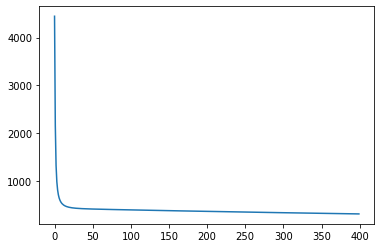

In [ ]:
x2 = np.array(range(0, len(costList)))

fig2 = plt.figure()
fig2.add_axes()

plt.plot(x2, costList)
plt.show()

In [ ]:
# coefficient RDD
coefRdd = sc.parallelize(r).zipWithIndex()

In [ ]:
# five words with the largest regression coefficients save to list and look up
five = coefRdd.top(5, key = lambda x: x[0])
pos5 = []
for x in five:
    pos5.append(x[1])

In [ ]:
# flip the words and position number of the dictionary to look up words by index
reverseDict = dictionary.map(lambda x: (x[1], x[0]))

In [ ]:
#print out the top 5 words associated with Autralian court docs
sc.parallelize(getfp(reverseDict, pos5)).coalesce(1).saveAsTextFile("test2")
    

In [ ]:
# calculate prediction value on the train set
textModelwThetaRDD = textModelRDD.map(lambda x: (x[0], x[1], calcTheta(x[1], r)))

textModelwPredictionRDD = textModelwThetaRDD.map(lambda x: (x[0], (0 if x[2] < 0 else 1)))

#confusion matrix [labeled, predicted]
#TP [1, 1]
#FP [0, 1]
#FN [1, 0]
#TN [0, 0]
confMatrixRDD = textModelwPredictionRDD.map(lambda x: ((x[0], x[1]),1)).reduceByKey(lambda a, b: a+b)


In [ ]:
confMatrixRDD.collect()

[((0, 0), 3368), ((1, 0), 74)]

In [ ]:
# Accuracy: (TN + TP) / (TN + TP + FN + FP)
accuracy = (3366+0)/(3366+74+2)
# Recall: TP/(TP+FN)
recall = (0/(0+74))
# Precision: TP/(TP+FP)
precision = (0/(0+2))

# F ratio = 2(precision*Recall)/(precision+recall)
#f_ratio = 2*((recall*precision)/(recall+precision))


print('accuracy={} recall={} precision={}'.format(accuracy, recall, precision))

accuracy=0.9779198140615921 recall=0.0 precision=0.0


In [ ]:
## From Big Data Run:

Confusion Matrix:
> ((0, 0), 18339) = TN
> ((1, 0), 169) = FN
> ((1, 1), 208) = TP
> ((0, 1), 8) = FP

In [ ]:
TN = 18339
FN = 169
TP = 208
FP = 8

Accuracy = (TN + TP) / (TN + TP + FN + FP)
Recall = TP/(TP+FN)
Precision = TP/(TP+FP)

F_ratio = 2*(Precision*Recall)/(Precision+Recall)

In [ ]:
print('Accuracy = ', Accuracy)
print('Recall = ', Recall)
print('Precision = ', Precision)

print('F Ratio = ', F_ratio)

Accuracy =  0.9905468916898099
Recall =  0.5517241379310345
Precision =  0.9629629629629629
F Ratio =  0.7015177065767285
